In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurkal

from importlib import reload

import itertools
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import derivative
import seaborn as sns

In [3]:
## Plot style setup
sns.set_style("whitegrid")
palette = itertools.cycle(sns.color_palette())

In [4]:
def gen_input_act(a, b=2, c=1, d=0.01):
    def input_act(x, x_i):
        return a * (np.exp(b * (np.cos(x - x_i) - c)) + d)
    def input_act_d(x, x_i):
        return -a * b * np.sin(x - x_i) * np.exp(b * (np.cos(x - x_i) - c))
    return input_act, input_act_d

In [5]:
input_act, input_act_d = gen_input_act(3, 2, 1, 0.01)

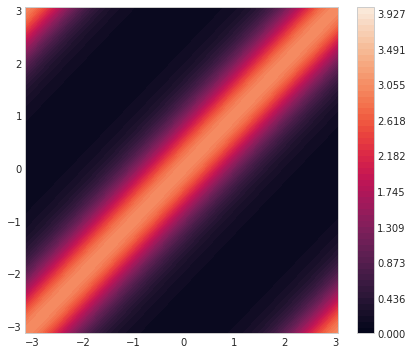

In [6]:
## Visualize activation function for sensory input layer
act = np.vectorize(input_act)
x = np.arange(-np.pi, np.pi, 0.1)
z = act(*np.meshgrid(x, x))
levels = np.linspace(np.floor(np.min(z)), np.ceil(np.max(z)), 56)

fig, ax = plt.subplots(figsize=(7, 6))
act_cf = ax.contourf(x, x, z, levels=levels)
plt.colorbar(act_cf)
plt.show()

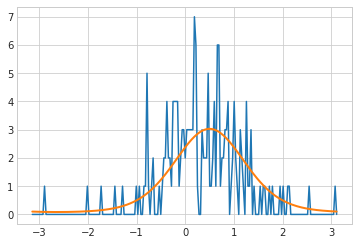

In [9]:
## Sensory input layer example activation
sensory_code = neurkal.PopCode(shape=200, act_func=input_act, dist=np.random.poisson)
activity = sensory_code(0.5)
plt.plot(sensory_code.prefs[0], activity)
plt.plot(sensory_code.prefs[0], sensory_code.mean_activity, lw=2)
plt.show()

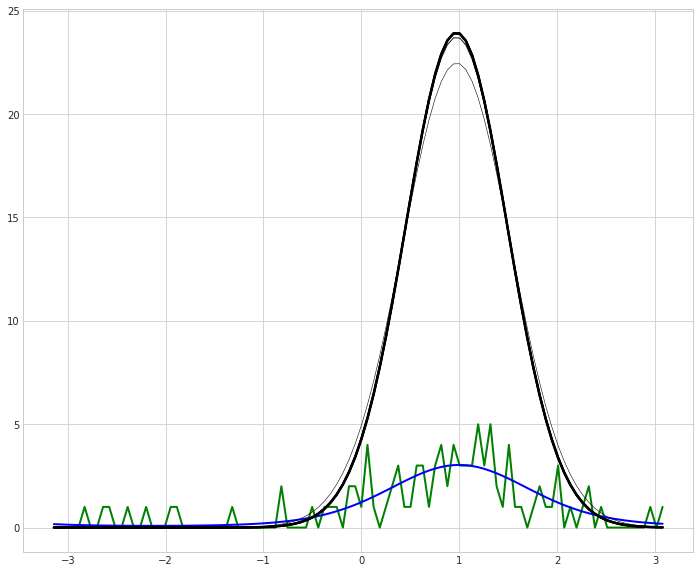

In [11]:
## Example evolution of noisy activity in recurrent network
def gaussian_filter(k_w, p, delta):
    def filt(i, k):
        return k_w * np.exp((np.cos(2*np.pi*(i - k)/p) - 1) / delta**2)
    return filt

# parameters
x = 1  # actual sensory input
p = 100  # number of units in network
delta = 0.5  # controls width of Gaussian filter giving recurrent weights
k_w = 1  # gain of recurrent connections
S = 0  # divisive normalization constant
mu = 0.002  # divisive normalization weight
steps = 500

filt = gaussian_filter(k_w, p, delta)

recurrent_net = neurkal.RecurrentPopCode(weight_func=filt, S=S, mu=mu, shape=p, 
                                         act_func=input_act, dist=np.random.poisson)
recurrent_net(x)  # initialize by (noisy) sampling
prefs = recurrent_net.prefs[0]
cr_bound2 = recurrent_net.cr_bound

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(prefs, recurrent_net.activity, 'g', lw=2)
ax.plot(prefs, recurrent_net.mean_activity, 'b', lw=2)
for i in range(steps):
    recurrent_net.step()
    if i in [0, 2, 5, 10, 20, 40, 80, 160, steps]:
        ax.plot(prefs, recurrent_net.activity, 'k', lw=0.5*np.log(i+1))
plt.show()

In [12]:
cr_bound2

0.003590903230303068

In [209]:
# Cramer-Rao bounds
dx_f = np.array([input_act_d(x, x_i) for x_i in recurrent_net.prefs[0]])
cr_bound = 1 / np.matmul(np.matmul(dx_f, np.diag(fs)), dx_f.T)

In [210]:
f_ = [(lambda x_i: (lambda x_: input_act(x_, x_i)))(x_i) for x_i in recurrent_net.prefs[0]]
dx_f_ = np.array([derivative(f, x, dx=0.1) for f in f_])
cr_bound_ = 1 / np.matmul(np.matmul(dx_f_, np.diag(fs)), dx_f_.T)

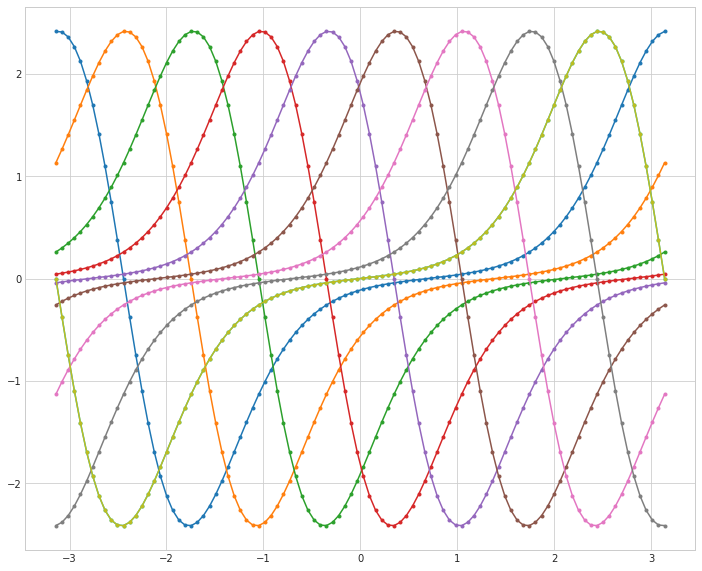

In [194]:
# testing analytical vs. numerical derivation
r = np.linspace(-np.pi, np.pi, 100)
prefs = np.linspace(-np.pi, np.pi, 10)
fig, ax = plt.subplots(figsize=(12, 10))
for p in prefs:
    color = next(palette)
    f_ = lambda x_: input_act(x_, p)
    d_f_0 = np.array([input_act_d(x_, p) for x_ in r])
    d_f_1 = np.array([derivative(f_, x_, dx=0.001) for x_ in r])
    ax.plot(r, d_f_0, '-', color=color)
    ax.plot(r, d_f_1, '.', color=color)
    

In [183]:
cr_bound

0.0035904206216371922

In [160]:
# analyse variance of resulting estimates
trials = 1000
steps = 50

estimates = []

for t in range(trials):
    recurrent_net = neurkal.RecurrentPopCode(weight_func=filt, S=S, mu=mu, shape=p, 
                                             act_func=input_act, dist=np.random.poisson)
    recurrent_net(x)
    for i in range(steps):
        recurrent_net.step()
    estimates.append(recurrent_net.prefs[0][np.argmax(recurrent_net.activity)])
estimates = np.array(estimates)
var = np.sum((estimates - x) ** 2) / (trials - 1)

TypeError: input_act_d() missing 1 required positional argument: 'x_i'

In [162]:
var

0.009725755949606786

In [163]:
cr_bound

0.0035904206216371922

In [ ]:
# TODO: variance in estimates versus average firing rates and other parameters

In [141]:
# example basis network, for experiments
sensory_codes = [neurkal.PopCode(shape=4, act_func=input_act, dist=np.random.poisson),
                neurkal.PopCode(shape=7, act_func=input_act, dist=np.random.poisson)]
basis = neurkal.KalmanBasisNetwork(sensory_codes)

TypeError: __init__() missing 3 required positional arguments: 'motor_inputs', 'mu', and 'eta'